In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
# 1. Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')


# 3. Vérifier le contenu du dataset (optionnel)
!ls /content/drive/MyDrive/projet_yolo_medical/data/images/train | head -20
!ls /content/drive/MyDrive/projet_yolo_medical/data/labels/train | head -20


# 4. Importer YOLO et configurer le modèle
from ultralytics import YOLO


Mounted at /content/drive
01.jpg
02.jpg
03.jpg
04.jpg
05.jpg
06.jpg
07.jpg
08.jpg
09.jpg
10.jpg
11.jpg
12.jpg
13.jpg
14.jpg
15.jpg
16.jpg
17.jpg
18.jpg
19.jpg
20.jpg
01.txt
02.txt
03.txt
04.txt
05.txt
06.txt
07.txt
08.txt
09.txt
10.txt
11.txt
12.txt
13.txt
14.txt
15.txt
16.txt
17.txt
18.txt
19.txt
20.txt
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8m.pt')  # ou yolov8n.pt si tu veux plus léger

model.train(
    data='/content/drive/MyDrive/projet_yolo_medical/data.yaml',
    epochs=100,
    imgsz=640,
    batch=64,                  # A100 -> tu peux monter
    device=0,
    project='/content/drive/MyDrive/projet_yolo_medical',
    name='runs_a100',
    exist_ok=True,

    # Optimisation fine
    optimizer="AdamW",
    lr0=1e-3,
    lrf=0.01,
    weight_decay=0.001,
    momentum=0.937,            # laisser valeur par défaut d’Ultralytics

    # Early stopping
    patience=20,

    # Augmentations (médical-friendly)
    mosaic=1.0,
    mixup=0.2,
    close_mosaic=10,           # désactive mosaic dans les 10 dernières epochs
    hsv_h=0.015,
    hsv_s=0.5,
    hsv_v=0.4,
    degrees=5.0,
    translate=0.1,
    scale=0.5,
    shear=2.0,
    flipud=0.0,
    fliplr=0.0,

    # Divers
    verbose=True,
    amp=True,                  # ⚡️ A100 = mixed precision activée
    workers=8
)



0: 448x640 2 haemorrhagess, 9 hard_exudatess, 1 optic_disc, 12.0ms
1: 448x640 1 hard_exudates, 1 optic_disc, 12.0ms
2: 448x640 1 optic_disc, 12.0ms
3: 448x640 1 hard_exudates, 1 optic_disc, 12.0ms
4: 448x640 1 haemorrhages, 3 hard_exudatess, 1 optic_disc, 12.0ms
Speed: 3.2ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


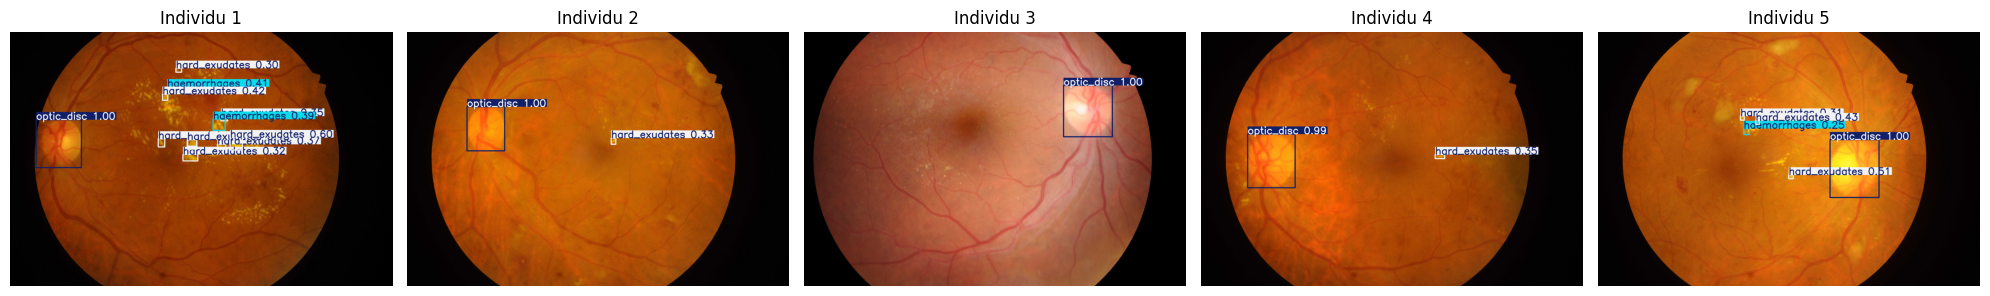

In [9]:
import matplotlib.pyplot as plt
import cv2
import os
from ultralytics import YOLO
from glob import glob

# Charger le modèle entraîné
model = YOLO('/content/drive/MyDrive/projet_yolo_medical/runs_a100/weights/best.pt')

# Récupérer les chemins d’images test (JPG/PNG)
test_images_dir = '/content/drive/MyDrive/projet_yolo_medical/data/images/test'
image_paths = sorted(glob(f'{test_images_dir}/*.jpg'))[:5]  # ⚠️ ici on limite à 5 images pour l’exemple

# Prédictions
results = model.predict(source=image_paths, conf=0.25, show=False)

# Affichage
n_images = len(results)
plt.figure(figsize=(n_images * 4, 5))  # chaque image prend 4 unités de largeur

for i, result in enumerate(results):
    # Charger l’image prédite avec les bounding boxes
    im_pred = result.plot()  # retourne une image avec les boîtes tracées

    plt.subplot(1, n_images, i + 1)
    plt.imshow(cv2.cvtColor(im_pred, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Individu {i+1}")

plt.tight_layout()
plt.show()



image 1/1 /content/drive/MyDrive/projet_yolo_medical/data/images/test/65.jpg: 448x640 11 microaneurysmss, 9 haemorrhagess, 31 hard_exudatess, 1 optic_disc, 13.7ms
Speed: 4.2ms preprocess, 13.7ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


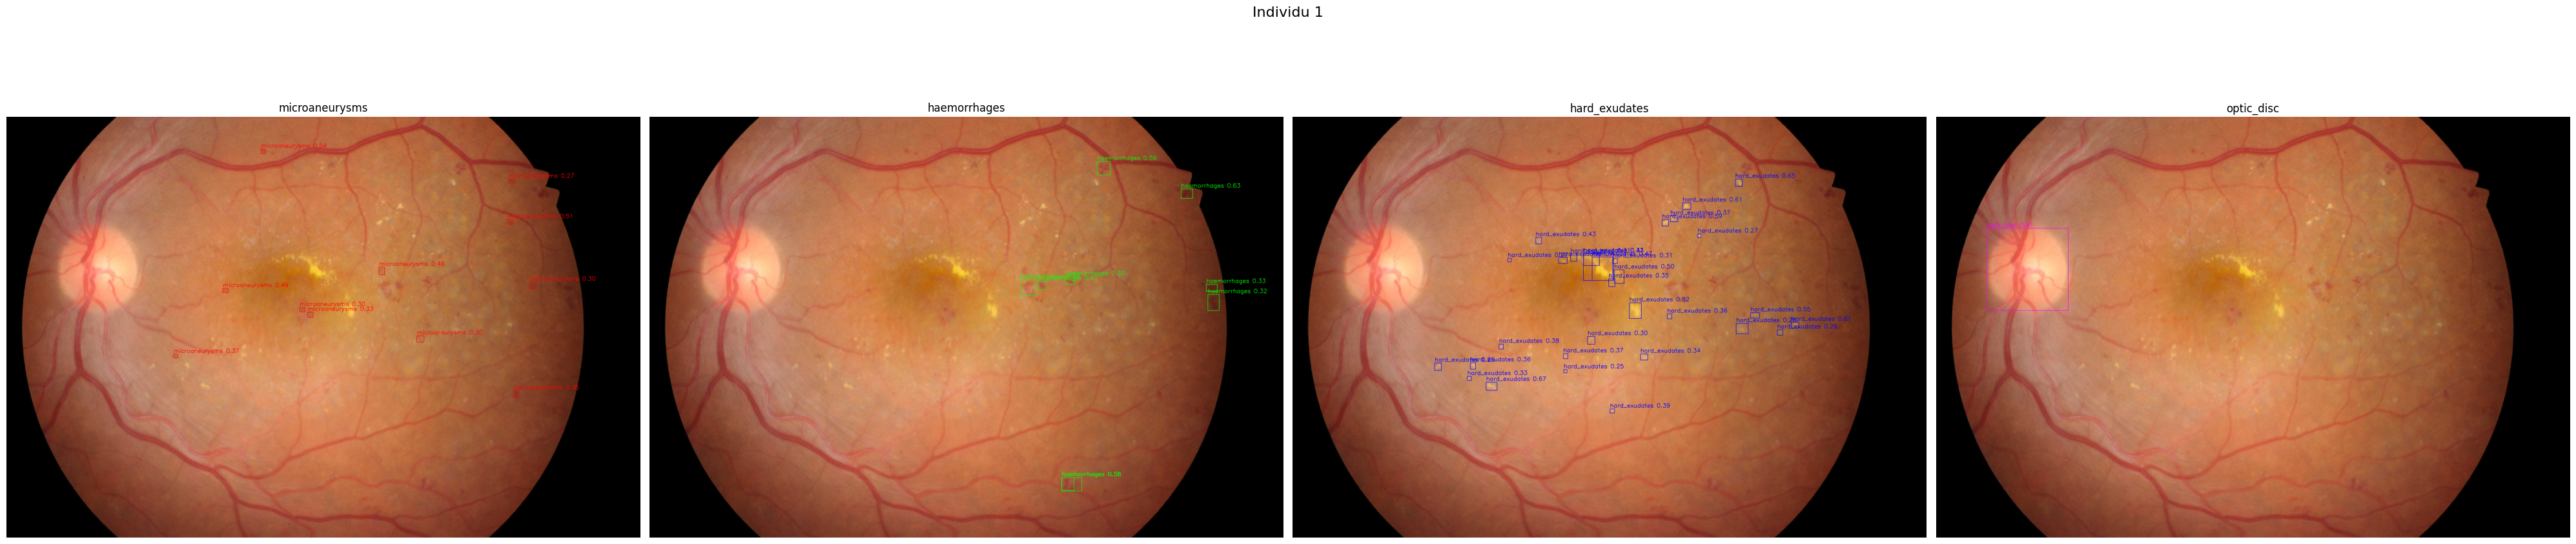


image 1/1 /content/drive/MyDrive/projet_yolo_medical/data/images/test/64.jpg: 448x640 4 microaneurysmss, 2 haemorrhagess, 19 hard_exudatess, 2 soft_exudatess, 1 optic_disc, 14.7ms
Speed: 5.9ms preprocess, 14.7ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)


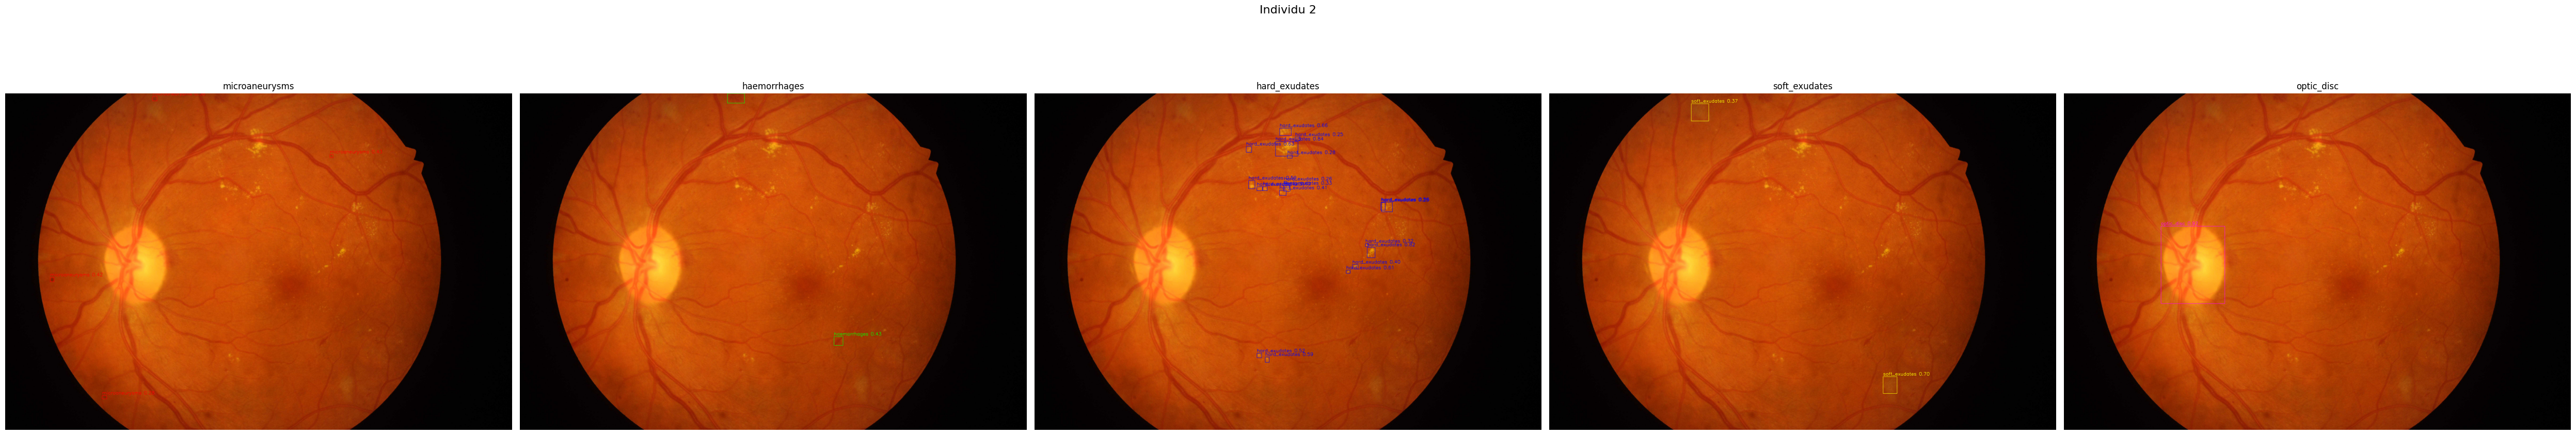


image 1/1 /content/drive/MyDrive/projet_yolo_medical/data/images/test/63.jpg: 448x640 1 haemorrhages, 26 hard_exudatess, 1 optic_disc, 11.0ms
Speed: 3.2ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


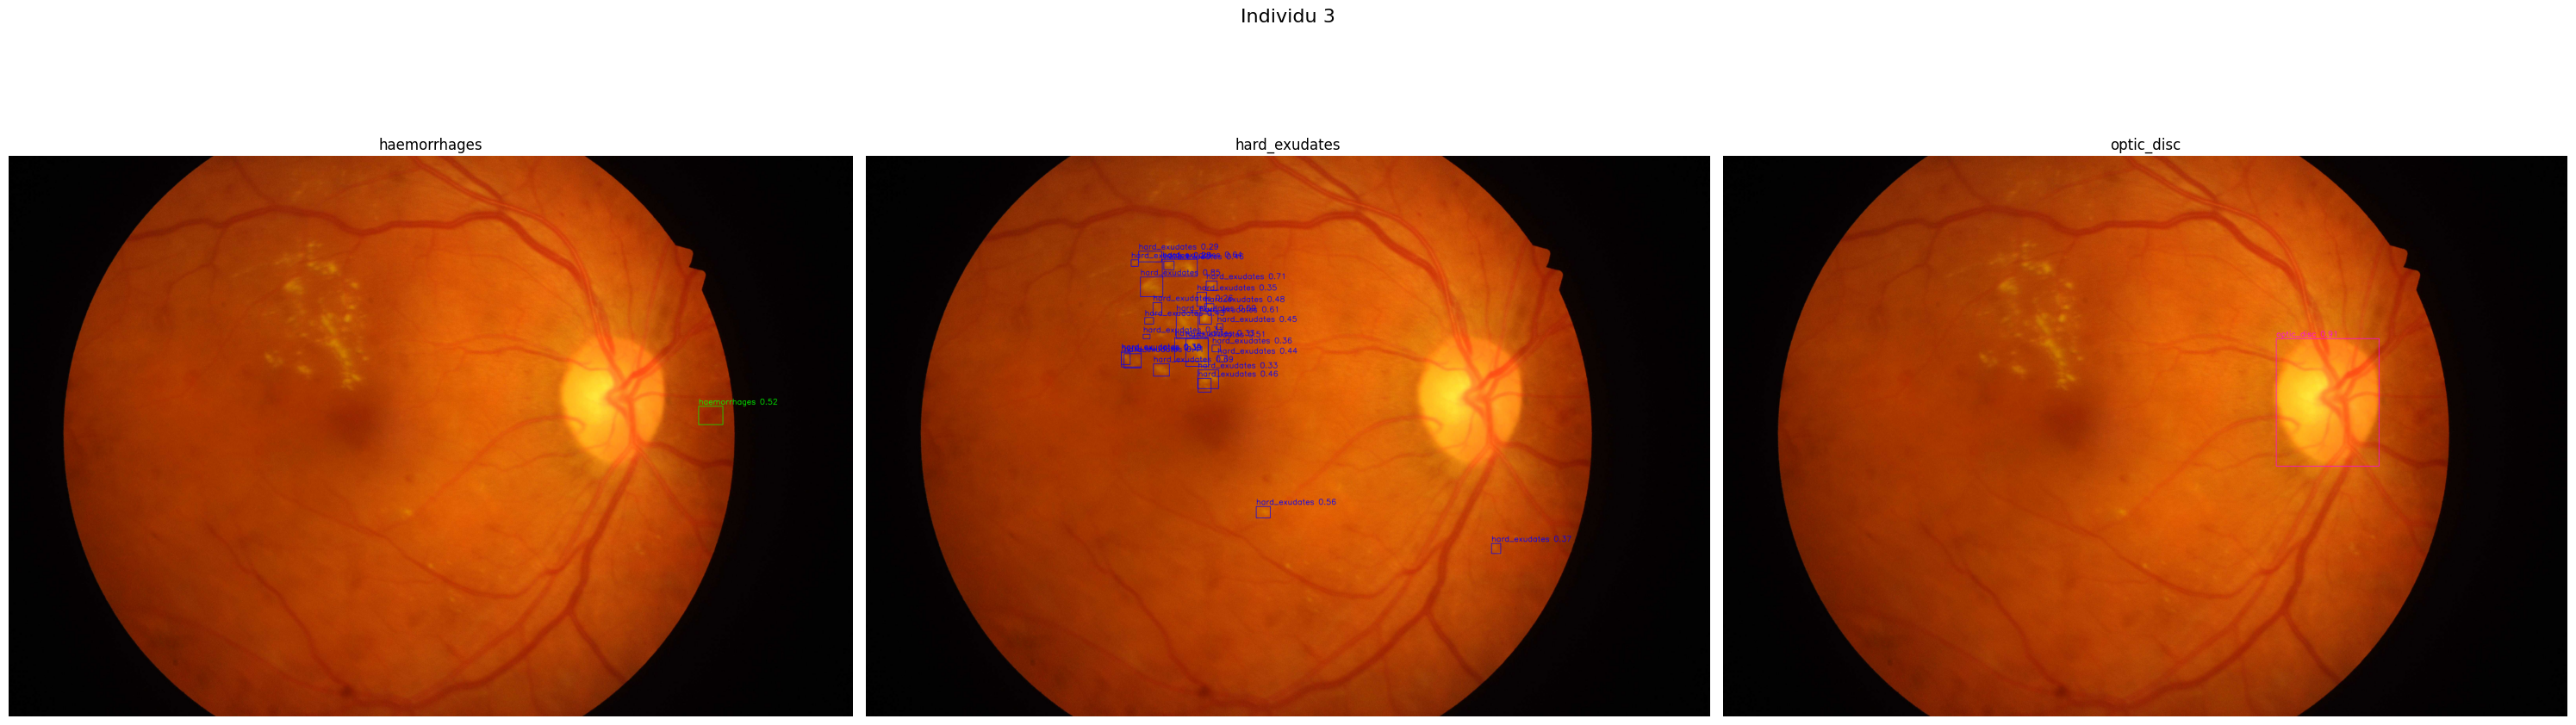

In [12]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os

# 🔧 Chemins des images à prédire
image_paths = [
    '/content/drive/MyDrive/projet_yolo_medical/data/images/test/65.jpg',
    '/content/drive/MyDrive/projet_yolo_medical/data/images/test/64.jpg',
    '/content/drive/MyDrive/projet_yolo_medical/data/images/test/63.jpg'
]

# ✅ Charger le modèle
model = YOLO('/content/drive/MyDrive/projet_yolo_medical/runs/weights/best.pt')

# 📂 Dossier de sortie
os.makedirs("outputs", exist_ok=True)

# 🔁 Pour chaque image (individu)
for img_idx, image_path in enumerate(image_paths):
    # Prédiction
    results = model.predict(source=image_path, conf=0.25)
    result = results[0]

    # Extraire les données
    boxes = result.boxes
    cls_ids = boxes.cls.cpu().numpy().astype(int)
    conf_scores = boxes.conf.cpu().numpy()
    xyxy = boxes.xyxy.cpu().numpy()

    # Classes et couleurs
    class_names = ['microaneurysms', 'haemorrhages', 'hard_exudates', 'soft_exudates', 'optic_disc']
    class_colors = {
        0: (255, 0, 0),      # rouge
        1: (0, 255, 0),      # vert
        2: (0, 0, 255),      # bleu
        3: (255, 255, 0),    # jaune
        4: (255, 0, 255),    # magenta
    }

    # Classes présentes
    present_classes = np.unique(cls_ids)

    # Charger image
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 🖼️ Subplots en ligne : 1 ligne, n colonnes (1 par classe)
    n = len(present_classes)
    fig, axs = plt.subplots(1, n, figsize=(10 * n, 10))
    if n == 1:
        axs = [axs]

    for i, class_id in enumerate(present_classes):
        ax = axs[i]
        img_copy = img_rgb.copy()

        # Boîtes de cette classe
        idxs = np.where(cls_ids == class_id)[0]
        for idx in idxs:
            x1, y1, x2, y2 = xyxy[idx].astype(int)
            conf = conf_scores[idx]
            color = class_colors[class_id]
            label = f"{class_names[class_id]} {conf:.2f}"

            cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_copy, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.3, color, 2)

        # Sauvegarder image annotée
        output_filename = f"outputs/output{img_idx + 1}_{class_id}.png"
        output_bgr = cv2.cvtColor(img_copy, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_filename, output_bgr)

        # Afficher
        ax.imshow(img_copy)
        ax.axis('off')
        ax.set_title(class_names[class_id])

    # Titre général par individu
    fig.suptitle(f"Individu {img_idx + 1}", fontsize=16)
    plt.tight_layout()
    plt.show()


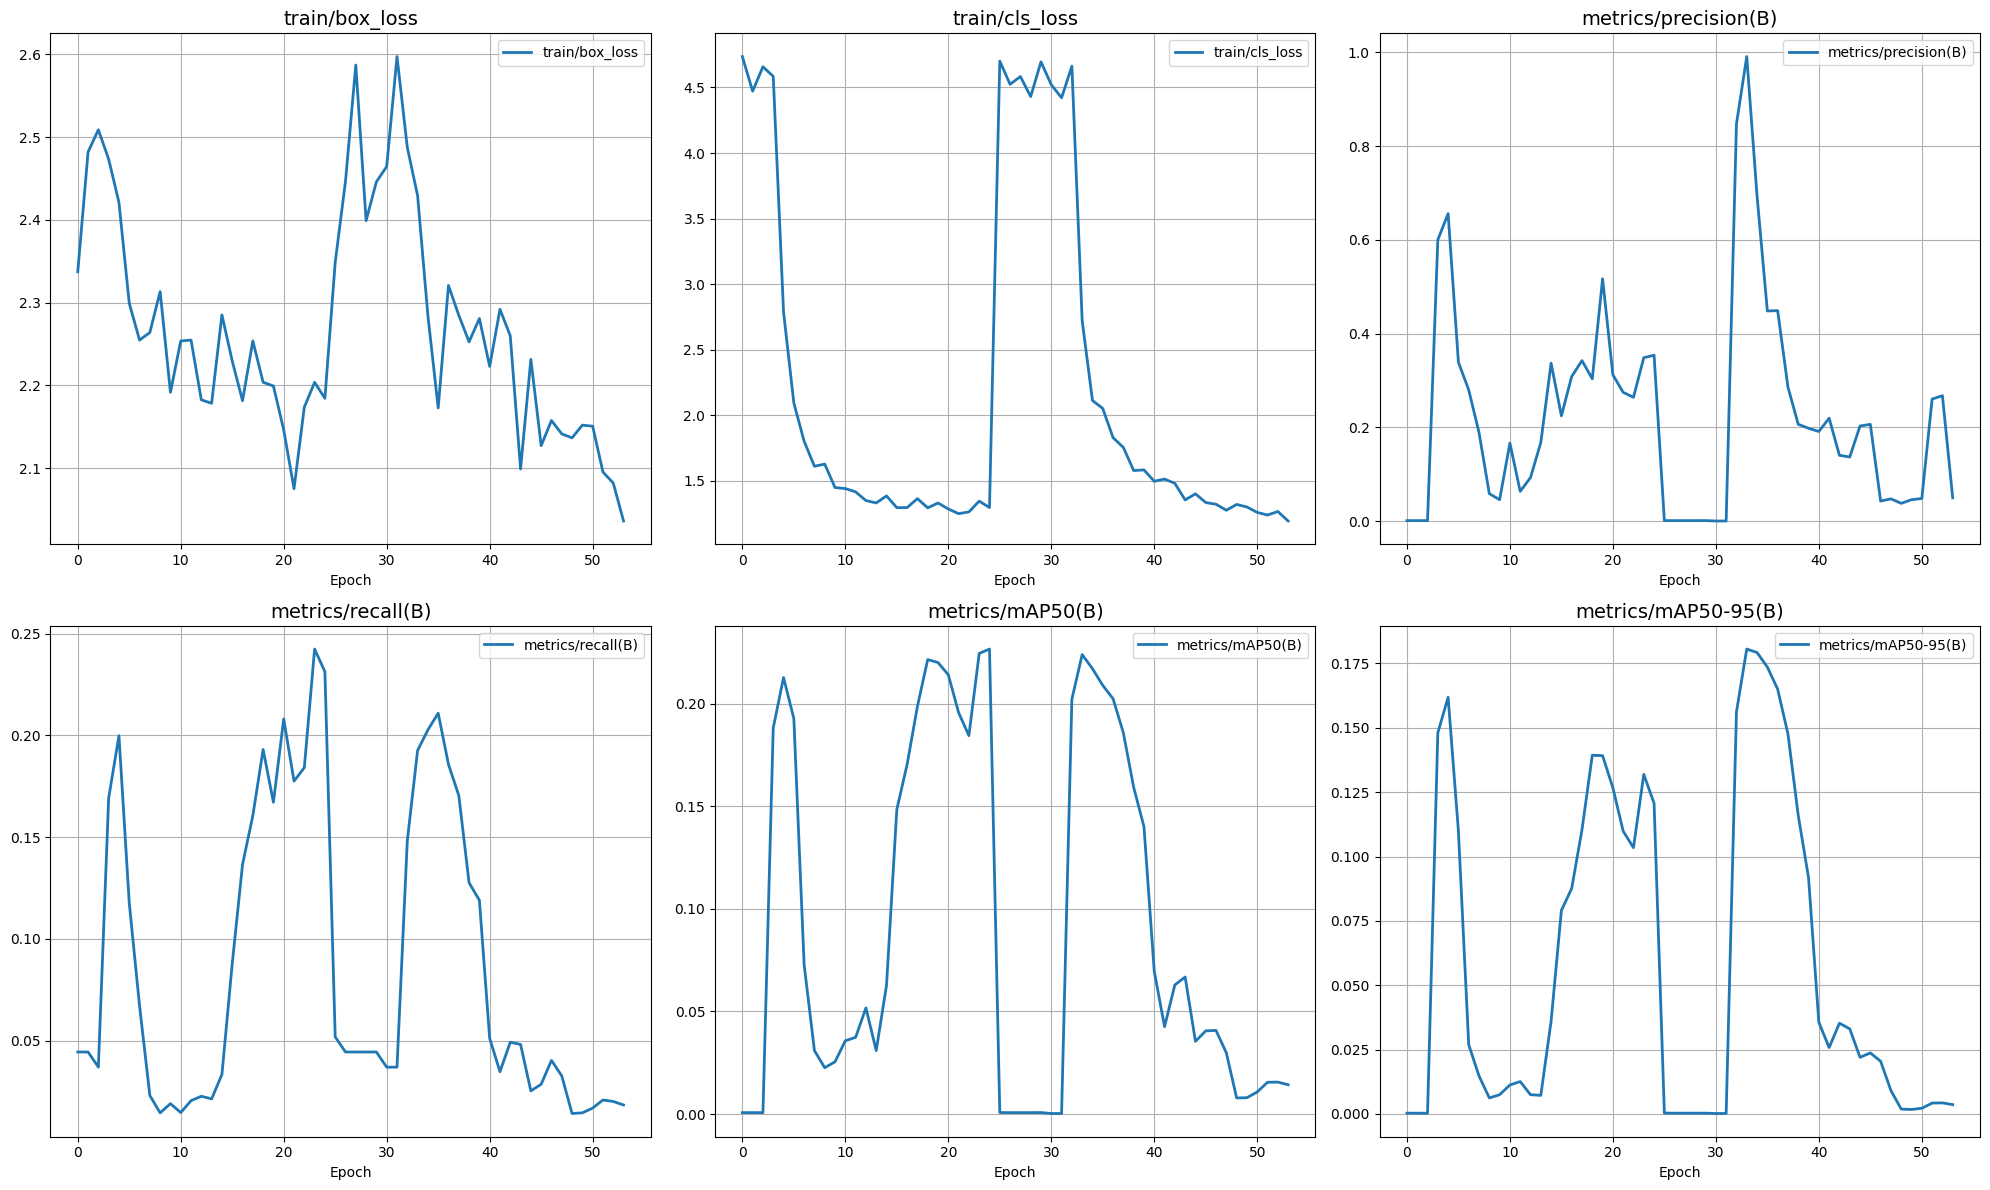

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les métriques
results_path = "/content/drive/MyDrive/projet_yolo_medical/runs_a100/results.csv"
df = pd.read_csv(results_path)

# Liste des colonnes à tracer
metrics = ['train/box_loss', 'train/cls_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']

# Tracer chaque métrique
plt.figure(figsize=(20, 12))  # 📐 grande figure
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    plt.plot(df[metric], label=metric, linewidth=2)
    plt.title(metric, fontsize=14)
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()
